# Fisher Analysis
In this notebook we explore the Fisher metric with quantized models.

In [12]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean




# import modules from JTAG model
module_path = os.path.abspath(os.path.join('../../workspace/models/jets/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import model as jet_tagger
import jet_datamodule

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ
import autoencoder_datamodule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from fisher import FIT



## Utility methods

In [13]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()
    
def plot_fisher_trace_per_layer(value, 
                                title, 
                                x_label='Layers', 
                                y_label='Fisher trace'):
    plt.figure(figsize=(12,6))
    
    plt.bar(value.keys(), 
            value.values())

    plt.ylim(0, 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()

In [14]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [15]:
DATA_PATH = '/home/jovyan/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'
ECON_layers = ['encoder.conv', 'encoder.enc_dense']

precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]


In [16]:
def get_estimated_fisher(batch_size, 
                         learning_rate, 
                         precision,
                         size, 
                         dataloader,
                         min_it=100,
                         max_it=1000,
                         load=True):
    '''
    Get the value of the Fisher matrix
    '''
    
    # path to the directory
    path = os.path.join(
        DATA_PATH, 
        f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/'
    )
    
    # load the model and the performance
    model, emd = econ.load_model(DATA_PATH, batch_size, learning_rate, precision, size)
    
    # instantiate the metric
    metric = FIT(model, 
                 dataloader, 
                 input_spec=(batch_size, 1, 8, 8),
                 target_layers=ECON_layers)
    
    # try to load the result
    if load:
        if metric.load_from_file(path):
            return metric.results
        else:
            print("Information not stored in ", path)
    
    # compute the result and store it
    result = metric.EF(min_iterations=min_it, max_iterations=max_it)
    metric.save_on_file(path=path)
    
    return result

## Results

Neural efficiency require to process an input sample per time. 

In [17]:
noise = 5 # 5 10 15 20
noise_type = 'gaussian'

[0. 0.]


[0. 0.]
[0. 0.]
[0. 0.]
[9.6384092e-06 3.0660423e-05]
[0.00014719 0.00011916]
[0.00080199 0.00594465]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[3.2658751e-05 7.3591604e-05]
[4.5965743e-04 7.2470109e-05]
[0.00034256 0.00015084]
[0. 0.]
[0. 0.]
[8.9580717e-24 2.1478239e-24]
[4.4097088e-04 7.3238829e-05]
[2.3947209e-06 3.5495916e-07]
[2.143416e-05 9.347765e-06]
[1.3748617e-05 1.1188790e-05]
[0. 0.]
[0. 0.]
[1.2512677e-26 9.2956673e-27]
[0. 0.]
[0.00272022 0.00342662]
[0.00052663 0.00026307]
[0.01417896 0.02122813]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.00934924 0.00486669]
[0.05446682 0.18411131]
[2.2208059e-04 7.6032506e-05]
[0. 0.]
[0. 0.]
[6.e-45 0.e+00]
[2.2017053e-05 9.2943719e-06]
[2.7016908e-04 8.0213351e-05]
[0.00291447 0.00100188]
[0.01655995 0.01884225]
[0. 0.]
[0. 0.]
[3.644651e-40 1.864136e-39]
[6.6706487e-15 1.5434956e-14]
[1.4483169 5.783221 ]
[0.01471691 0.00706319]
[0.28335163 0.51661885]


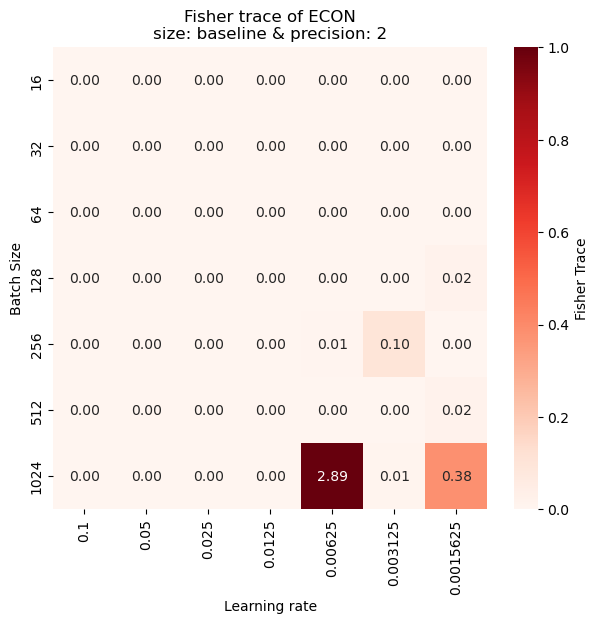

[0. 0.]
[0. 0.]
[0.70965844 0.01602208]
[0.00368618 0.00174915]
[0.04177133 0.00104358]
[0.01513843 0.00254166]
[0.01390635 0.00350021]
[0. 0.]
[0. 0.]
[0. 0.]
[0.01573614 0.00161958]
[0.01399624 0.00037972]
[0.00406344 0.00118727]
[2.2045162e-05 1.0039550e-04]
[0. 0.]
[0. 0.]
[5.8856269e-31 2.1721003e-31]
[0. 0.]
[0.0007362  0.00157232]
[0.00052242 0.00022676]
[8.8629255e-05 4.9693776e-05]
[0. 0.]
[0. 0.]
[0.00261495 0.00027848]
[0.09034509 0.03811842]
[0.00078528 0.00044572]
[0.00033003 0.00020855]
[0.00072236 0.00019925]
[0. 0.]
[0. 0.]
[2.8736334e-30 3.5629521e-31]
[0.01814049 0.00022081]
[0.00066897 0.00011297]
[0.01434582 0.00825648]
[0.00363489 0.00088842]
[0. 0.]
[0. 0.]
[6.17949e-39 8.53349e-40]
[0.00594276 0.00018492]
[0.00010076 0.00035354]
[0.00077106 0.00019067]
[0.00786948 0.00253079]
[0. 0.]
[0. 0.]
[1.9221296e-35 4.2605902e-36]
[0.02013301 0.00085445]
[0.01652115 0.00468774]
[0.0122011 0.004404 ]
[0.08729517 0.01246327]


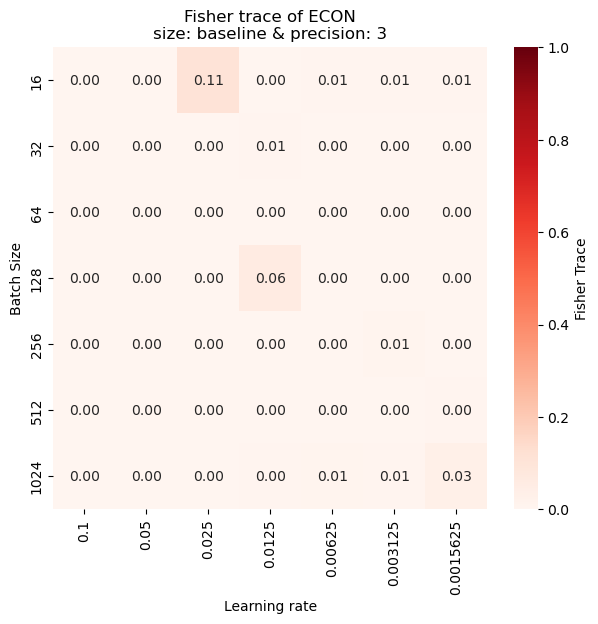

[0. 0.]
[0. 0.]
[0.01820373 0.00583667]
[0.06663615 0.00162085]
[0.33130288 0.00132929]
[0.04539663 0.00013913]
[0.01673299 0.00010684]
[0. 0.]
[0. 0.]
[0.0271605  0.00022637]
[0.12885153 0.0007624 ]
[0.67210484 0.00315738]
[0.00161886 0.00013287]
[0.00119956 0.00018994]
[0. 0.]
[1.3083e-41 9.0244e-43]
[0.04802968 0.00070227]
[0.48913068 0.00117436]
[0.04826837 0.00012078]
[2.5646042e-03 9.8791010e-05]
[6.1267586e-03 6.4025400e-05]
[0. 0.]
[0. 0.]
[2.5883485e-27 1.5345257e-28]
[0.14564787 0.0002369 ]
[0.00015733 0.00033662]
[0.00479779 0.00013941]
[0.06595708 0.00055522]
[0. 0.]
[1.4913658e-20 9.3864522e-22]
[2.814133e-22 3.527946e-23]
[0.16239122 0.00085034]
[0.01362602 0.00020653]
[0.02829309 0.00027124]
[0.0434206  0.00076055]
[0. 0.]
[0. 0.]
[1.5157729e-30 1.4093373e-31]
[0.09910285 0.00378425]
[0.29854515 0.00082135]
[0.02491033 0.00072233]
[0.04393233 0.00236942]
[0. 0.]
[0. 0.]
[1.856645e-34 2.712119e-35]
[0. 0.]
[0.06691289 0.00191474]
[0.13467282 0.00352304]
[0.04576911 0.0054

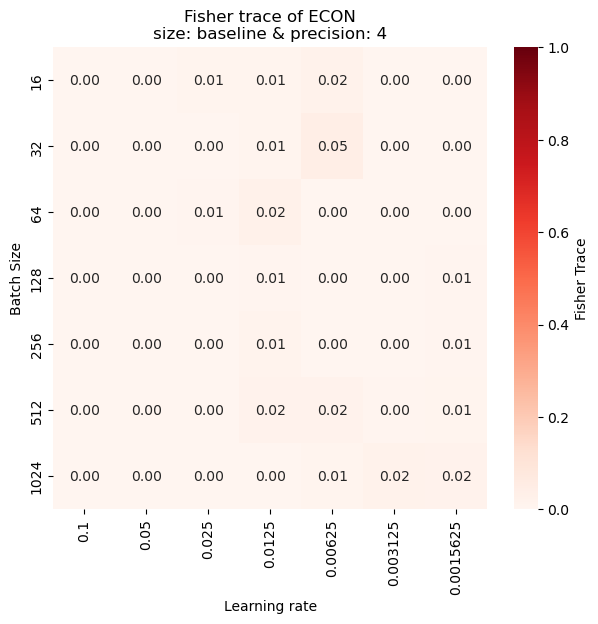

[0. 0.]
[0. 0.]
[0.01045985 0.00398973]
[0.16242126 0.01470662]
[0.21121413 0.00235441]
[1.6449039e-01 1.5156357e-04]
[0.29207382 0.00203073]
[0. 0.]
[0. 0.]
[0. 0.]
[0.06725678 0.00183966]
[2.6465511e-01 1.5439141e-04]
[0.16656795 0.00018395]
[5.8154726e-01 3.1428266e-04]
[0. 0.]
[0. 0.]
[8.2633421e-25 1.8871307e-25]
[0.01913111 0.0013658 ]
[0.22629835 0.00037043]
[3.7558928e-01 6.6977009e-05]
[0.2226385  0.00052613]
[0. 0.]
[0. 0.]
[5.5826664e-01 1.2425047e-04]
[0.246315  0.0003629]
[1.8992996e-01 4.7417583e-05]
[1.1607594e+00 8.2390048e-05]
[1.1042361e+00 2.8679211e-04]
[0. 0.]
[0. 0.]
[9.440073e-20 8.070409e-21]
[4.3807176e-01 2.7828681e-04]
[0.08145291 0.00058044]
[0.12224654 0.00046608]
[0.18624584 0.00066003]
[0. 0.]
[0. 0.]
[1.0702665e-28 1.4341820e-29]
[0.49078533 0.00087782]
[0.26757962 0.00105726]
[1.1805462e+00 4.5025768e-04]
[0.42508957 0.00298716]
[0. 0.]
[0. 0.]
[5.7100135e-24 7.8050642e-25]
[0.5209285  0.00289085]
[1.1148     0.00209441]
[0.1834673 0.0033579]
[0.1348036

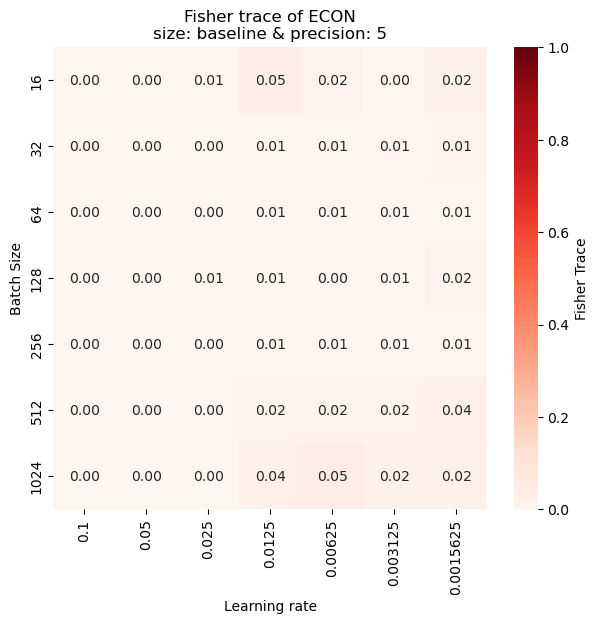

[0. 0.]
[0. 0.]
[0. 0.]
[0.10246323 0.01163946]
[0.18279901 0.00649344]
[0.14957489 0.00067197]
[0.33244237 0.00058722]
[0. 0.]
[4.2454e-41 6.1853e-42]
[0.06708227 0.00586818]
[0.20281507 0.00177022]
[0.06397032 0.0006696 ]
[0.15619045 0.0003733 ]
[3.9419979e-01 2.7298107e-04]
[0. 0.]
[0. 0.]
[0.19458546 0.0040841 ]
[0.11691144 0.00038831]
[1.7419335e-01 7.2461386e-05]
[4.6406710e-01 1.8601966e-04]
[9.4340193e-01 1.8698951e-04]
[0. 0.]
[0. 0.]
[0.01500088 0.00014914]
[0.22234201 0.00029035]
[7.1050489e-01 2.2726547e-04]
[1.2915665e+00 1.8112508e-04]
[1.8711332e+00 8.8103354e-04]
[0. 0.]
[0. 0.]
[0. 0.]
[0.6954421 0.0009443]
[8.0307204e-01 2.5947997e-04]
[1.7332914e+00 4.3168303e-04]
[1.9692045e+00 4.7220351e-04]
[0. 0.]
[2.6319725e-16 1.2846445e-17]
[1.3106123e-18 4.6948203e-20]
[1.1643597e+00 2.8090517e-04]
[0.21419767 0.00497578]
[0.53382224 0.00168122]
[0.16689713 0.00153149]
[0. 0.]
[0. 0.]
[2.7957787e-20 2.9158783e-21]
[3.7312717e+00 3.4239827e-04]
[0.7597012  0.00183678]
[0.56805

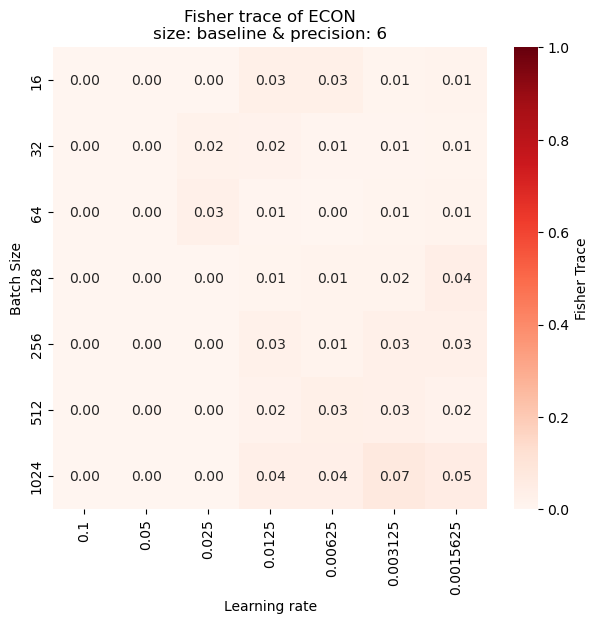

[0. 0.]
[0. 0.]
[0.11765281 0.04042745]
[0.13223512 0.03473197]
[0.1544372  0.00333119]
[0.17132783 0.00172806]
[0.29837102 0.0029575 ]
[0. 0.]
[2.68612e-40 2.42327e-41]
[0.06827009 0.00121768]
[0.0517058  0.00201659]
[0.09471024 0.00028363]
[0.30149114 0.00150638]
[0.23091003 0.00075441]
[0. 0.]
[0. 0.]
[0.07471026 0.00857036]
[0.15121743 0.00060995]
[0.3137356  0.00060604]
[0.5022797  0.00053659]
[0.5526035  0.00191322]
[0. 0.]
[0. 0.]
[4.3952767e-02 5.9416539e-05]
[0.21163037 0.0011496 ]
[7.691943e-01 6.105077e-04]
[1.0748801e+00 2.5420144e-04]
[9.899566e-01 5.318540e-04]
[0. 0.]
[0. 0.]
[0.39893886 0.00354639]
[4.5270187e-01 1.5608316e-04]
[2.1009221e+00 2.2249932e-04]
[1.2316133e+00 5.6355982e-04]
[1.0633094  0.00128872]
[0. 0.]
[0. 0.]
[1.5963412e-22 1.6475273e-23]
[1.5143077e+00 6.6278118e-04]
[3.4543059e+00 1.2084886e-03]
[2.3274155e+00 9.1320492e-04]
[0.2045942  0.00422867]
[0. 0.]
[0. 0.]
[4.3095032e-21 5.5482655e-22]
[0.78062916 0.00084658]
[1.511053  0.0033812]
[1.2786672  

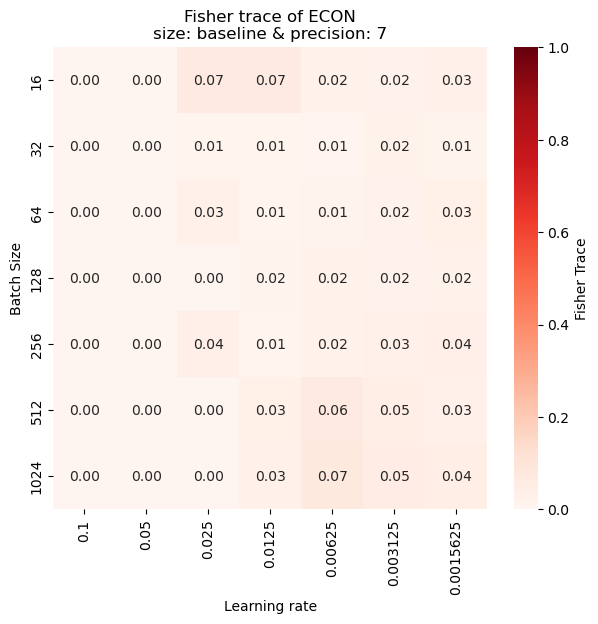

[0. 0.]
[0. 0.]
[0.02877655 0.01445482]
[0.07759973 0.03591669]
[0.10087885 0.00108292]
[0.24726172 0.00080807]
[0.33709353 0.01003855]
[0. 0.]
[0.09162253 0.01555256]
[0.07476264 0.00143631]
[0.0877959  0.00255711]
[0.12482624 0.00075092]
[0.0935439  0.00080645]
[0.2091257  0.00127669]
[0. 0.]
[0. 0.]
[0.17359722 0.00561899]
[0.18353486 0.00618359]
[0.27986482 0.00038095]
[7.9145312e-01 2.6852195e-04]
[0.5404109  0.00141855]
[0. 0.]
[1.0659895e-37 1.3298380e-38]
[1.750235   0.00797703]
[0.47772837 0.00121281]
[5.5670244e-01 5.0172984e-04]
[0.7768928  0.00101657]
[0.6938393  0.00156892]
[0. 0.]
[0. 0.]
[10.096277    0.04672157]
[1.8540833e+00 1.1491674e-03]
[0.41788864 0.00111866]
[2.4831238e+00 6.8558200e-04]
[0.0638394  0.00444447]
[0. 0.]
[1.5118497e-38 2.5474849e-39]
[6.5262224e-20 1.3282498e-20]
[0.3289892  0.00181308]
[0.4637618  0.00122182]
[0.22776614 0.00206982]
[0.08485671 0.00688474]
[0. 0.]
[0. 0.]
[6.7066574e-19 6.4100475e-20]
[6.632298   0.00854484]
[0.2508748  0.00668355

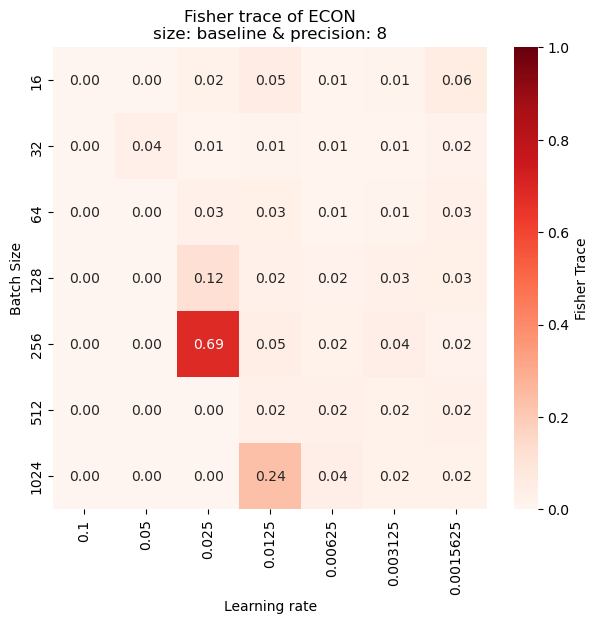

[0. 0.]
[0.02932145 0.18178952]
[0.04474223 0.22704165]
[0.06359599 0.01428872]
[0.32397392 0.01878057]
[0.22234659 0.00411233]
[0.18452822 0.00381145]
[0. 0.]
[5.59e-43 2.52e-44]
[1.7684336  0.02779564]
[0.07375739 0.00855369]
[0.0563605  0.00239179]
[0.19400181 0.0028422 ]
[0.18623798 0.00164931]
[0. 0.]
[0. 0.]
[0.1541992  0.01137741]
[0.10940012 0.00049088]
[0.10267521 0.00287147]
[0.5692865  0.00138353]
[0.10816951 0.0042298 ]
[0. 0.]
[0. 0.]
[0.29151398 0.01700763]
[0.20209251 0.00143612]
[0.2723285  0.00257505]
[0.4208629  0.00107814]
[0.21268699 0.00372835]
[0. 0.]
[0. 0.]
[9.9697778e-13 1.4036507e-13]
[0.4499593  0.00259504]
[8.7824082e-01 3.7204247e-04]
[0.6177366 0.0018372]
[0.21040165 0.00366142]
[3.8631574e-13 2.2178052e-15]
[1.9727928e-37 2.9366911e-38]
[3.2461849e-17 3.8331053e-18]
[0.32468352 0.00270922]
[0.55507827 0.00137812]
[0.39904368 0.00538845]
[0.07404195 0.0177481 ]
[0. 0.]
[0. 0.]
[1.43846527e-22 1.00458754e-23]
[0.53897035 0.00545202]
[0.3146075  0.00641941]


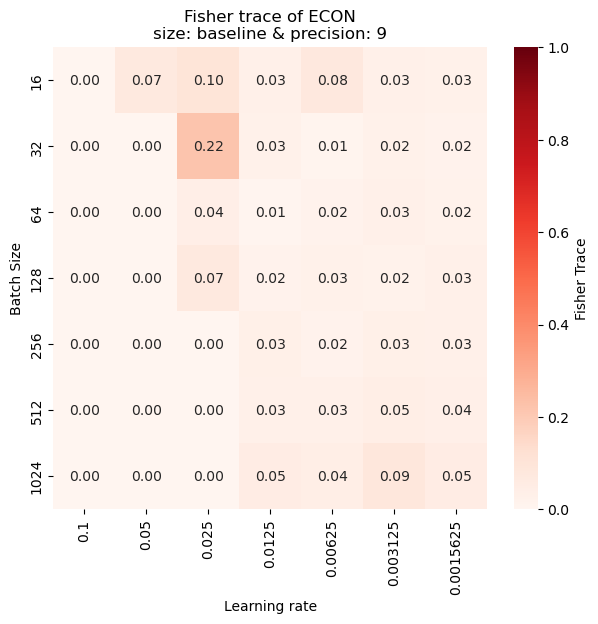

[0. 0.]
[5.9361581e-30 1.1130487e-30]
[0.02789897 0.0160815 ]
[0.05206067 0.0110833 ]
[0.25935623 0.01406785]
[0.15733242 0.01364584]
[0.12449282 0.00697393]
[0. 0.]
[0. 0.]
[0. 0.]
[0.12481176 0.01061462]
[0.07270928 0.00344583]
[0.09920353 0.00293661]
[0.16267732 0.00386466]
[0. 0.]
[3.41763e-40 9.66181e-41]
[0.20381816 0.01237694]
[0.1012316  0.00681637]
[0.08100066 0.00320375]
[0.3162207 0.001734 ]
[0.20237301 0.00586884]
[0. 0.]
[0. 0.]
[0.4015082  0.01049851]
[0.44588906 0.00207669]
[0.39763415 0.00123226]
[0.42793366 0.00151768]
[0.48373395 0.00289723]
[1.3670910e-34 1.2155241e-36]
[2.17e-43 3.64e-44]
[1.8085e-41 8.2957e-43]
[0.5295714  0.00454626]
[0.44824803 0.00278207]
[0.16996324 0.00395483]
[0.1163707 0.0066312]
[0. 0.]
[0. 0.]
[6.8497877e-20 7.6814254e-21]
[0.16473247 0.00527315]
[0.23835354 0.00388923]
[0.15400547 0.01155767]
[0.07717355 0.02030481]
[0. 0.]
[0. 0.]
[3.2479482  0.02932273]
[1.0739989  0.00316749]
[0.14708355 0.01637817]
[0.37030184 0.07440706]
[0.02431093 

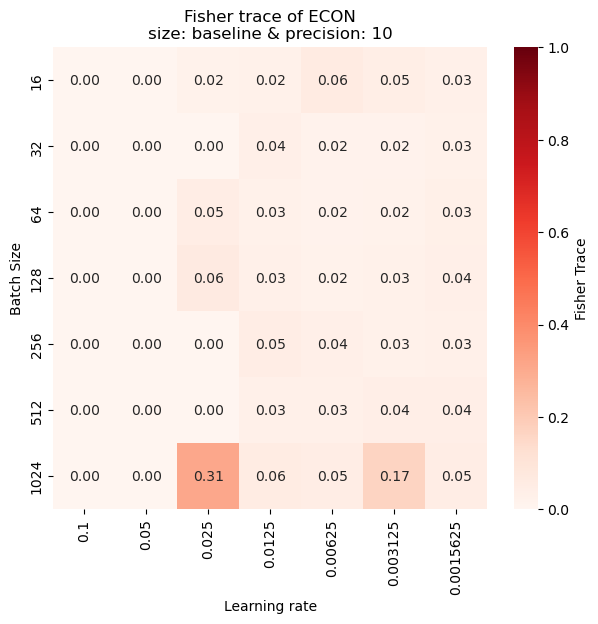

[0. 0.]
[0. 0.]
[0.01352413 0.01382588]
[0.16460787 0.05270463]
[0.06694803 0.00612742]
[0.18729386 0.01125919]
[0.18130475 0.00995122]
[0. 0.]
[1.763e-42 5.157e-43]
[1.1102877  0.17947736]
[0.08747388 0.00598206]
[0.0977025  0.00588417]
[0.12055016 0.00342742]
[0.12442227 0.00276304]
[0. 0.]
[0. 0.]
[0.10696776 0.01229488]
[0.11162756 0.0034682 ]
[0.092329   0.00282795]
[0.13839956 0.00189715]
[0.1677752  0.00514275]
[0. 0.]
[0. 0.]
[0.2568346  0.02335403]
[0.25103694 0.00246292]
[0.20681861 0.00203766]
[0.2931283  0.00417371]
[0.11695001 0.00844647]
[0. 0.]
[0. 0.]
[9.06476280e-23 1.05504025e-23]
[0.37857908 0.00263633]
[0.34652674 0.00315369]
[0.17541581 0.00584617]
[0.20638578 0.01442645]
[0. 0.]
[1.0938343e-27 9.5068934e-29]
[1.9763879e-14 1.8431947e-15]
[1.1543214 0.0148035]
[0.16327177 0.00416324]
[0.10573035 0.01221639]
[0.0698413  0.01732091]
[0. 0.]
[0. 0.]
[7.4893759e-14 6.4311874e-15]
[0.11370572 0.0038486 ]
[0.08952224 0.02920097]
[0.13155477 0.02633926]
[0.10748491 0.0378

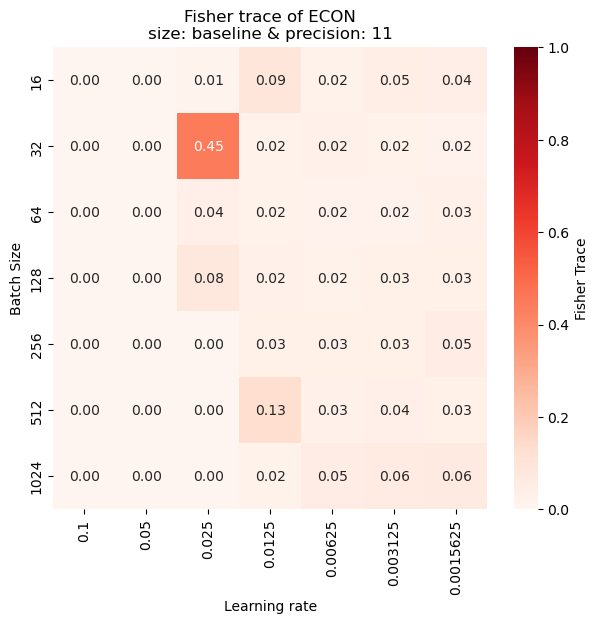

In [18]:
fisher_distribution = []
for p in precisions:
    fisher_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        fisher_dataloader = autoencoder_datamodule.get_data_module(DATASET_DIR, DATASET_FILE, bs)
        for y, lr in enumerate(learning_rates):
            
            # get the performances with and without noise
            mean_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            noise_emd = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, noise)
            
            # get the model
            model, _ = econ.load_model(DATA_PATH, bs, lr, p, size)
    
            # instantiate the metric
            metric = FIT(model, 
                        fisher_dataloader, 
                        input_spec=(bs, 1, 8, 8),
                        target_layers=ECON_layers)
            
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/ECON_{p}b/{size}/'
            )
            result = -1
            if metric.load_from_file(path):
                print(metric.results['EF_trace_w'])
                result = scipy.stats.mstats.gmean(metric.results['EF_trace_w'])
            
            # build the heatmap matrix
            fisher_matrix[x, y] = result
            
            # build the dataframe for further analysis
            fisher_distribution.append({
                'precision': p, 
                'avg_EF': result,
                'emd': mean_emd,
                'noise_emd': noise_emd,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (noise_emd - mean_emd) * 100 / mean_emd,
            })
            
    # plot the heatmaps per precision
    fisher_matrix = pd.DataFrame(fisher_matrix, 
                             index=batch_sizes, 
                             columns=learning_rates)
    plot_2d_heatmap(fisher_matrix, 
                    f'Fisher trace of ECON\nsize: {size} & precision: {p}', 
                    (0, max(max(fisher_matrix), 1)),
                    'Learning rate',
                    'Batch Size',
                    'Fisher Trace',
                    cmap='Reds')
    

In [19]:
fisher_distribution_df = pd.DataFrame(fisher_distribution)
# eport to CSV
fisher_distribution_df.to_csv("./results/econ/fisher.csv", index=False)

## Per layer analysis

In [20]:
MIN_EMD = 3
MAX_LOSS = 50
NUM_PLOT = 3

fisher_distribution_df = fisher_distribution_df.loc[
        (fisher_distribution_df.loss > -0.5) & 
        (fisher_distribution_df.emd < MIN_EMD) # &
        # (ne_distribution_df.loss < MAX_LOSS)
    ]
fisher_distribution_df.sort_values(by='loss', ascending=True, inplace=True)

In [21]:
best_df = fisher_distribution_df.head(NUM_PLOT)
for i in range(NUM_PLOT):
    print('-'*80)
    print('Low loss')
    _, dataloader = autoencoder_datamodule.get_data_module(DATASET_DIR, 
                                                           DATASET_FILE, 
                                                           int(best_df.iloc[i]['batch_size'])).dataloaders()
    print(len(dataloader))
    result = get_estimated_fisher(int(best_df.iloc[i]['batch_size']),
                                   float(best_df.iloc[i]['learning_rate']), 
                                   int(best_df.iloc[i]['precision']),
                                   size,
                                   dataloader)
    print(f"EMD:\t{best_df.iloc[i]['emd']}\n" \
          f"Loss:\t{best_df.iloc[i]['loss']}\n" \
          f"AVG Trace Fisher:\t{best_df.iloc[i]['avg_EF']}")
    plot_fisher_trace_per_layer(result['EF_trace_w'], 
                                     'ECON Fisher trace\n' \
                                     f'{best_df.iloc[i]}')

--------------------------------------------------------------------------------
Low loss
680
EMD:	1.7443809111913045
Loss:	-0.2304847494291542
AVG Trace Fisher:	0.010202659294009209


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

<Figure size 1200x600 with 0 Axes>

--------------------------------------------------------------------------------
High loss
Accuracy:	1.3663277626037598
Loss:	252.22089644122613
Network efficiency:	0.4475942992885123


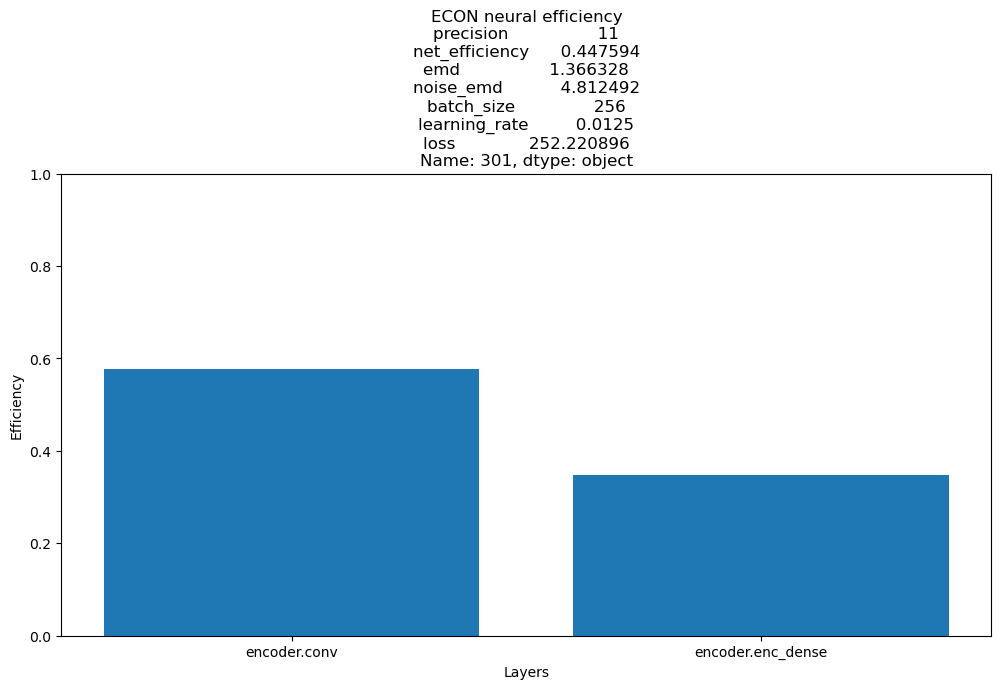

--------------------------------------------------------------------------------
High loss
Accuracy:	1.1998576720555623
Loss:	269.65530552378385
Network efficiency:	0.4588307921757274


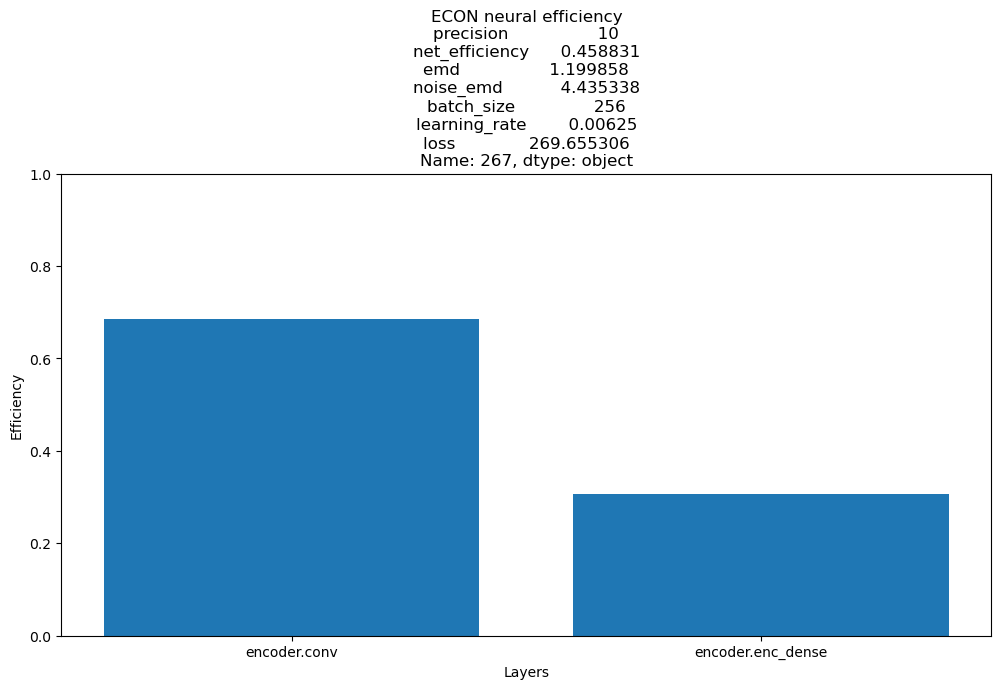

--------------------------------------------------------------------------------
High loss
Accuracy:	1.2699809869130452
Loss:	273.59714379027014
Network efficiency:	0.5712562010228729


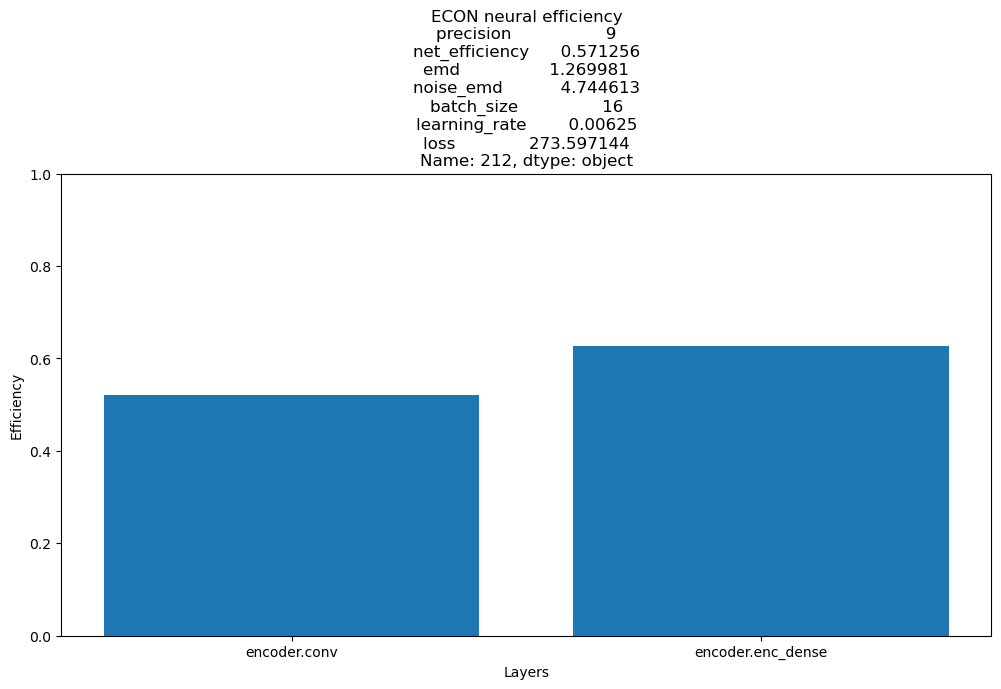

In [ ]:
worst_df = ne_distribution_df.tail(NUM_PLOT)

for i in range(NUM_PLOT):
    print('-'*80)
    print('High loss')
    result = get_neural_efficiency(int(worst_df.iloc[i]['batch_size']),
                                   float(worst_df.iloc[i]['learning_rate']), 
                                   int(worst_df.iloc[i]['precision']),
                                   size,
                                   ne_dataloader,
                                   max_batches=ne_batch_num)
    print(f"Accuracy:\t{worst_df.iloc[i]['emd']}\n" \
          f"Loss:\t{worst_df.iloc[i]['loss']}\n" \
          f"Network efficiency:\t{worst_df.iloc[i]['net_efficiency']}")

    plot_neural_efficiency_per_layer(result['layers_efficiency'], 
                                     'ECON neural efficiency\n' \
                                     f'{worst_df.iloc[i]}')

# Jet Tagger (MLP)
The full precision model achieve 76% of accuracy.

In [ ]:
DATA_PATH="/home/jovyan/checkpoint/"    
DATASET_DIR="../../data/JTAG"
DATASET_FILE=DATASET_DIR + "/processed_dataset.h5"

JTAG_layers = ['model.dense_1', 'model.dense_2', 'model.dense_3', 'model.dense_4']
# we do not consider extreme low precisions due to their performances
precisions = [4, 5, 6, 7, 8, 9, 10, 11]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]

In [ ]:
def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = JetDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # check if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module


def load_model(batch_size, learning_rate, precision):
    '''
    Method used to get the model and the relative accuracy
    '''
    accuracy, idx = get_model_index_and_relative_accuracy(batch_size, learning_rate, precision)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/JTAG_{precision}b/net_{idx}_best.pkl'
    
    # load the model
    model = JetTagger(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((16, 16)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, accuracy


def get_model_index_and_relative_accuracy(batch_size, learning_rate, precision, num_tests=5):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    performances = []
    max_acc = 0
    max_acc_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'JTAG_{precision}b/accuracy_{i}.txt'
        try:
            jtag_file = open(file_path)
            jtag_text = jtag_file.read()
            accuracy = ast.literal_eval(jtag_text)
            accuracy = accuracy[0]['test_acc']
            performances.append(accuracy)
            if accuracy >= max_acc:
                max_acc = accuracy
                max_acc_index = i
            jtag_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(performances) == 0:
        # warnings.warn(f"Attention: There is no accuracy value for the model: " \
        #               f"bs{batch_size}_lr{learning_rate}/JTAG_{precision}b")
        return
    
    return mean(performances), max_acc_index


def get_accuracy_with_noise(batch_size, learning_rate, precision, noise_type, percentage):
    '''
    Return the accuracy achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'JTAG_{precision}b/accuracy_{noise_type}_{percentage}.txt'
    noise_acc = -1
    try:
        acc_file = open(file_path)
        acc_text = acc_file.read()
        acc = ast.literal_eval(acc_text)
        noise_acc = acc[0]['test_acc']
        acc_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return 0
    return noise_acc


def get_neural_efficiency(batch_size, 
                          learning_rate, 
                          precision, 
                          dataloader,
                          load=True,
                          max_batches=None,
                          beta=2):
    '''
    Get the value of the Neural Efficiency
    '''
    
    # path to the directory
    path = os.path.join(
        DATA_PATH, 
        f'bs{batch_size}_lr{learning_rate}/JTAG_{precision}b/'
    )
    
    # load the model and the performance
    model, acc =load_model(batch_size, learning_rate, precision)
    
    # instantiate the metric
    metric = NeuralEfficiency(model, 
                              dataloader, 
                              performance=acc, 
                              max_batches=max_batches,
                              target_layers=JTAG_layers)
    
    # try to load the result
    if load:
        if metric.load_from_file(path):
            return metric.results
        else:
            print("Information not stored in ", path)
    
    # compute the result and store it
    result = metric.compute(beta=beta)
    metric.save_on_file(path=path)
    
    return result

## Results

Neural efficiency require to process an input sample per time. 


In [ ]:
noise = 5 # 5 10 15 20
noise_type = 'gaussian'
ne_dataloader = get_data_module(1).test_dataloader()

Loaded shaped data shape (train): (630000, 16)
Loaded shaped data datatype (train): float32
Loaded shaped data shape (val): (240000, 16)
Loaded shaped data datatype (val): float32


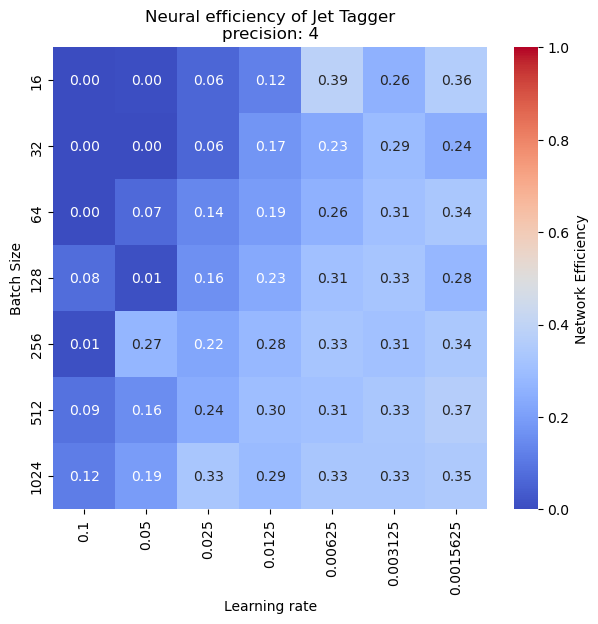

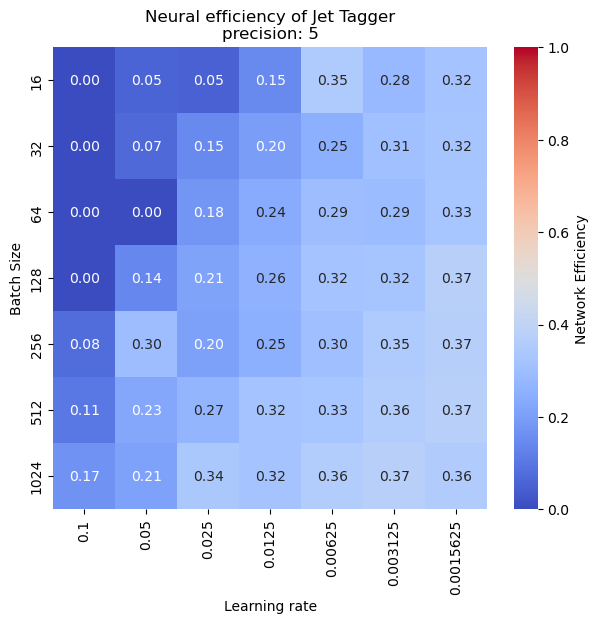

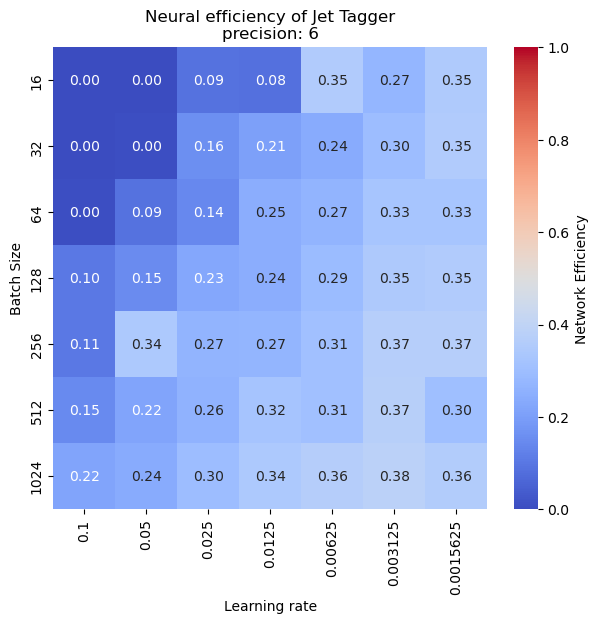

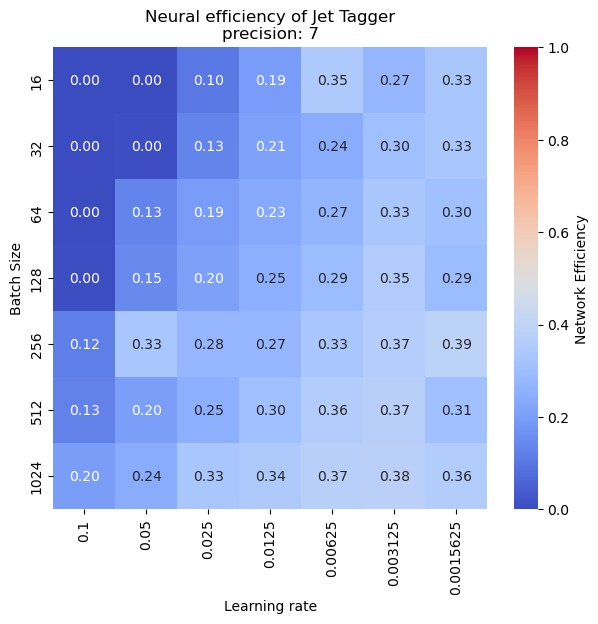

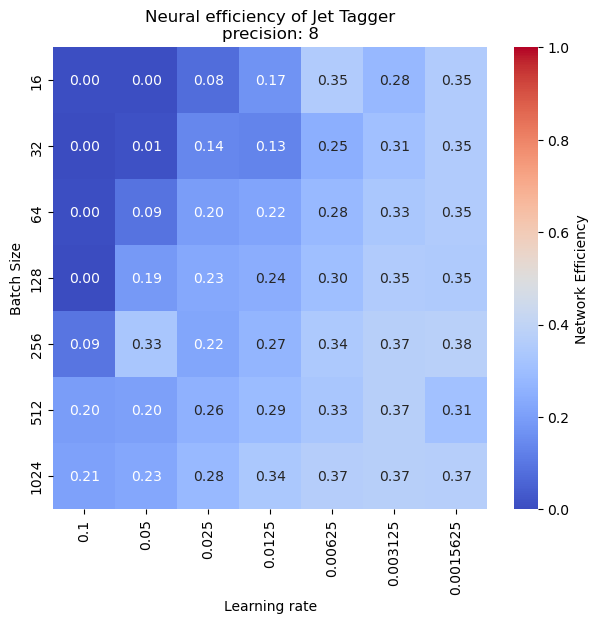

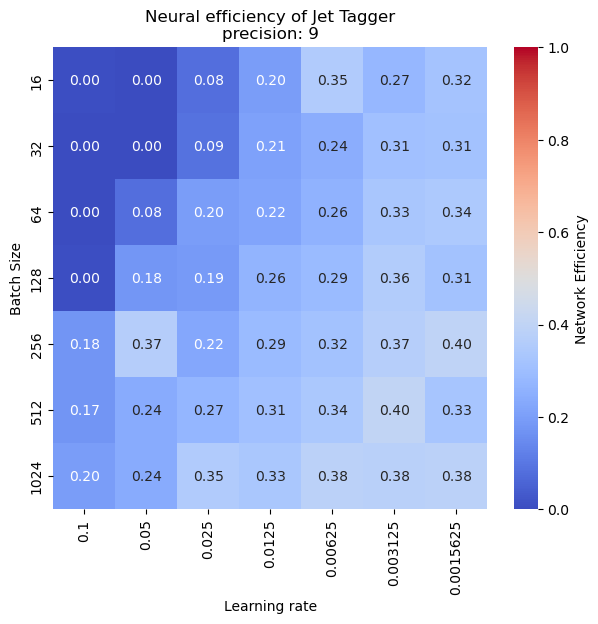

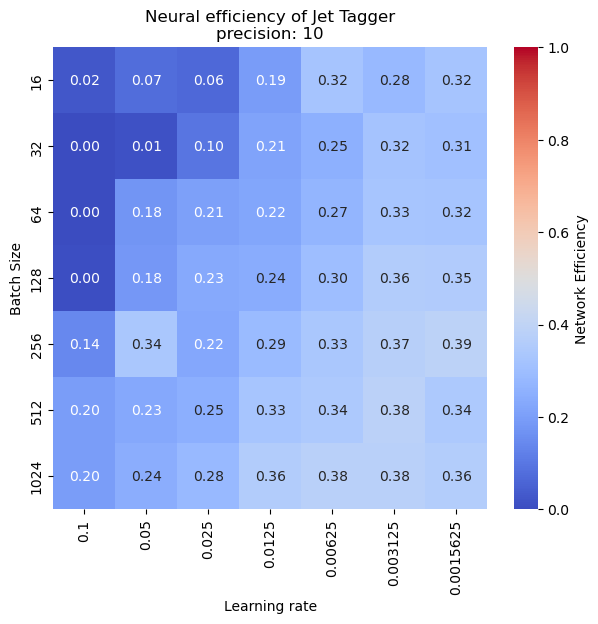

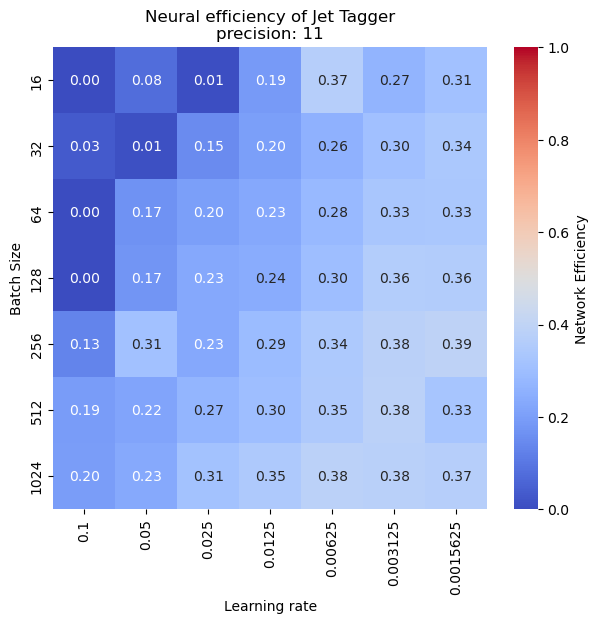

In [ ]:
ne_distribution = []
for p in precisions:
    NE_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            
            # get the performances with and without noise
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            noise_acc = get_accuracy_with_noise(bs, lr, p, noise_type, noise)
            
            # get the model
            model, _ = load_model(bs, lr, p)
            
            # instantiate the metric
            metric = NeuralEfficiency(model, 
                                      ne_dataloader, 
                                      performance=mean_acc, 
                                      max_batches=ne_batch_num,
                                      target_layers=JTAG_layers)
            
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/JTAG_{p}b/'
            )
            result = -1
            if metric.load_from_file(path):
                result = metric.results['network_efficiency']
                
            # build the heatmap matrix
            NE_matrix[x, y] = result
            
            # build the dataframe for further analysis
            ne_distribution.append({
                'precision': p, 
                'net_efficiency': result,
                'accuracy': mean_acc,
                'noise_acc': noise_acc,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (mean_acc - noise_acc) * 100 / mean_acc,
            })
            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=batch_sizes, 
                             columns=learning_rates)
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of Jet Tagger\nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Network Efficiency',
                    cmap='coolwarm')
    


In [ ]:
ne_distribution_df = pd.DataFrame(ne_distribution)

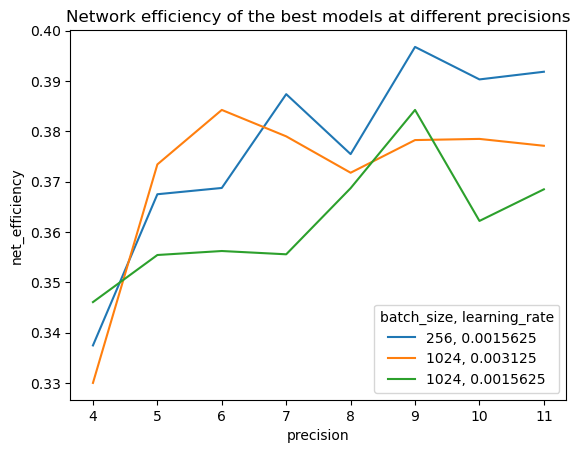

In [ ]:
top_5_df = ne_distribution_df.loc[
    (ne_distribution_df.batch_size == '1024') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '256') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '256') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '1024') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '1024') & (ne_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='net_efficiency', hue=hue)
plt.title("Network efficiency of the best models at different precisions")
plt.show()

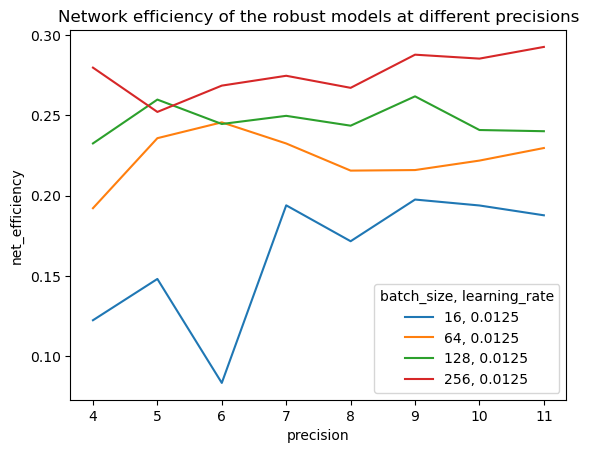

In [ ]:
top_5_df = ne_distribution_df.loc[
    (ne_distribution_df.batch_size == '16') & (ne_distribution_df.learning_rate == '0.0125') |
    (ne_distribution_df.batch_size == '64') & (ne_distribution_df.learning_rate == '0.0125') |
    (ne_distribution_df.batch_size == '256') & (ne_distribution_df.learning_rate == '0.0125') |
    (ne_distribution_df.batch_size == '16') & (ne_distribution_df.learning_rate == '0.03125') |
    (ne_distribution_df.batch_size == '128') & (ne_distribution_df.learning_rate == '0.0125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='net_efficiency', hue=hue)
plt.title("Network efficiency of the robust models at different precisions")
plt.show()

## Per layer analysis

In [ ]:
MAX_LOSS = 50
MIN_ACCURACY = 0.72
NUM_PLOT = 3

ne_distribution_df = ne_distribution_df.loc[
        (ne_distribution_df.loss > -0.5) & 
        (ne_distribution_df.accuracy > MIN_ACCURACY) # &
        # (ne_distribution_df.loss < MAX_LOSS)
    ]
ne_distribution_df.sort_values(by='loss', ascending=True, inplace=True)

--------------------------------------------------------------------------------
Low loss
Accuracy:	0.7236066579818725
Loss:	0.03949883399691837
Network efficiency:	0.19751480003633723


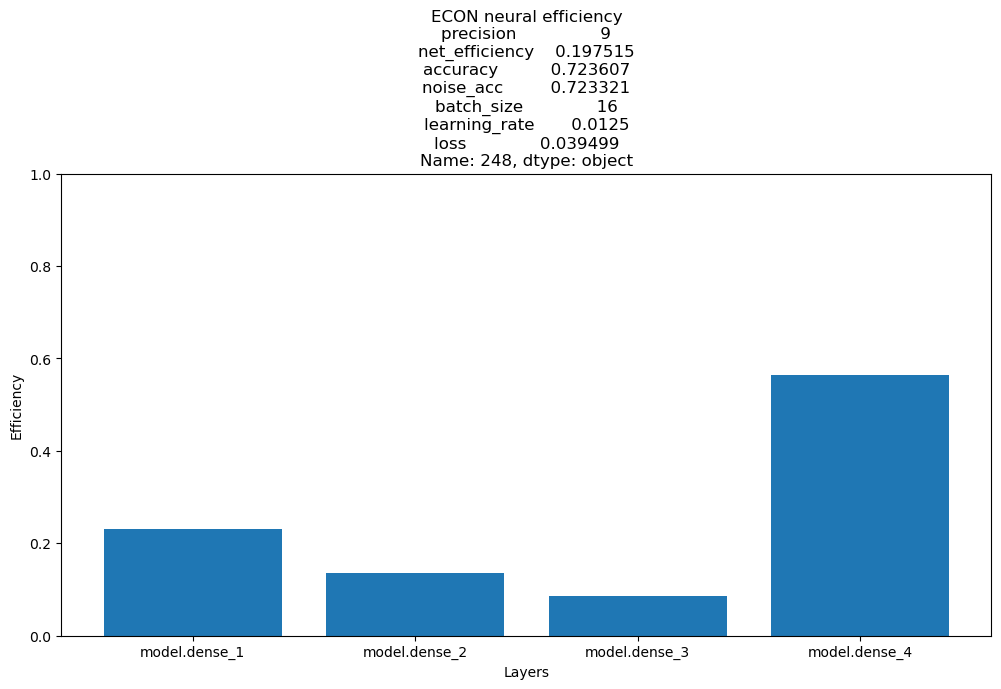

--------------------------------------------------------------------------------
Low loss
Accuracy:	0.7275750041007996
Loss:	0.329860290465477
Network efficiency:	0.14183045828436225


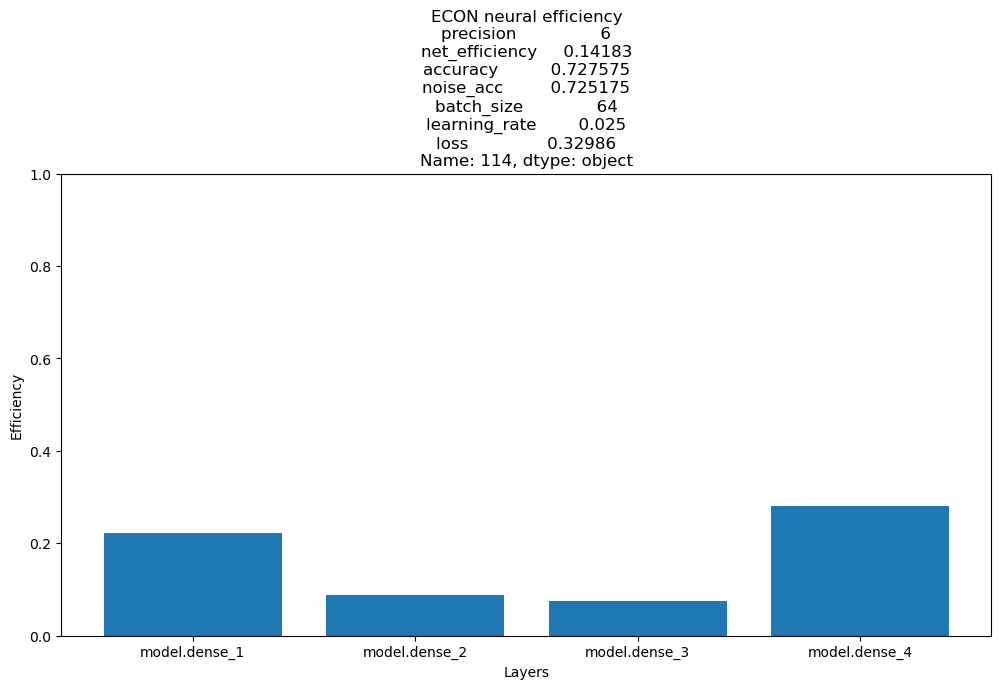

--------------------------------------------------------------------------------
Low loss
Accuracy:	0.724667489528656
Loss:	0.40201834148536963
Network efficiency:	0.2796946161622169


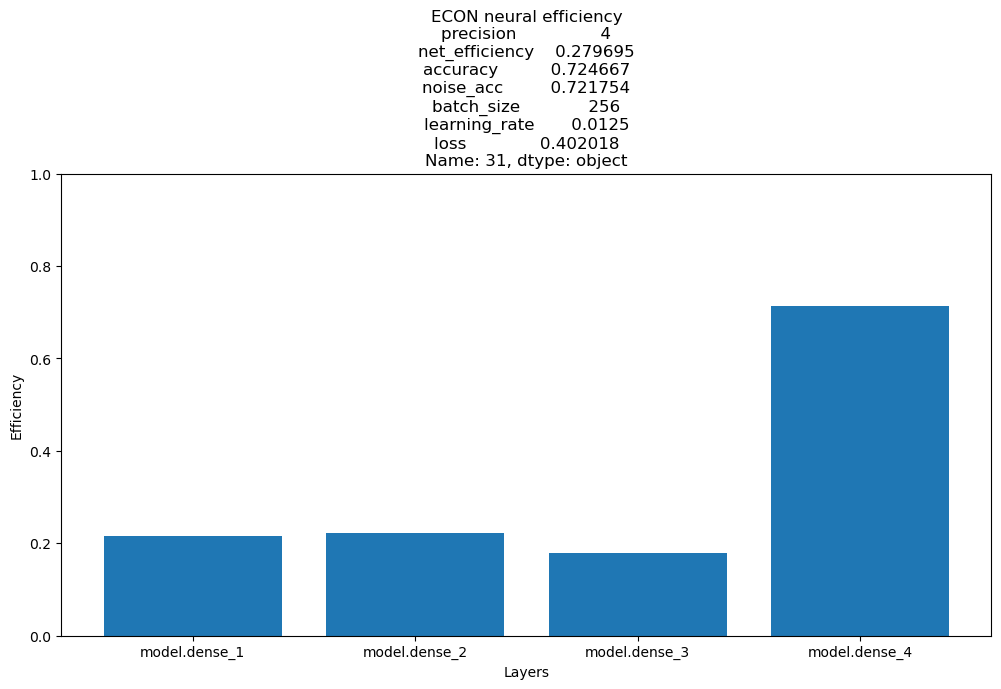

In [ ]:
best_df = ne_distribution_df.head(NUM_PLOT)
for i in range(NUM_PLOT):
    print('-'*80)
    print('Low loss')
    result = get_neural_efficiency(int(best_df.iloc[i]['batch_size']),
                                   float(best_df.iloc[i]['learning_rate']), 
                                   int(best_df.iloc[i]['precision']),
                                   ne_dataloader,
                                   max_batches=ne_batch_num)
    print(f"Accuracy:\t{best_df.iloc[i]['accuracy']}\n" \
          f"Loss:\t{best_df.iloc[i]['loss']}\n" \
          f"Network efficiency:\t{best_df.iloc[i]['net_efficiency']}")

    plot_neural_efficiency_per_layer(result['layers_efficiency'], 
                                     'ECON neural efficiency\n' \
                                     f'{best_df.iloc[i]}')

--------------------------------------------------------------------------------
High loss
Accuracy:	0.760420823097229
Loss:	73.5820620453879
Network efficiency:	0.2680655385131669


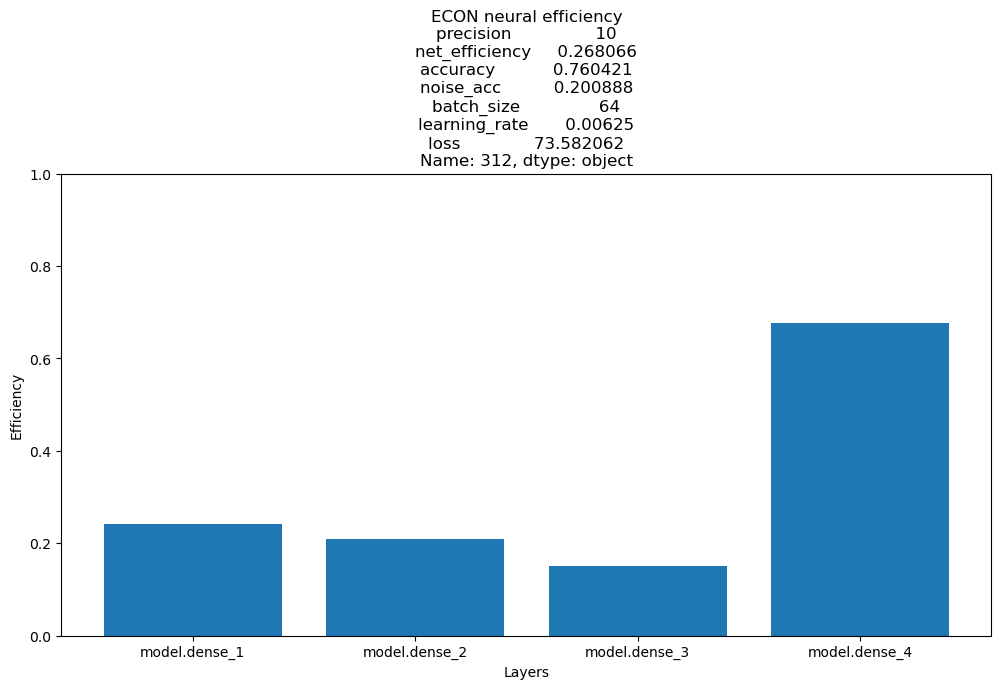

--------------------------------------------------------------------------------
High loss
Accuracy:	0.7595208406448364
Loss:	73.67528917779174
Network efficiency:	0.2668673578518543


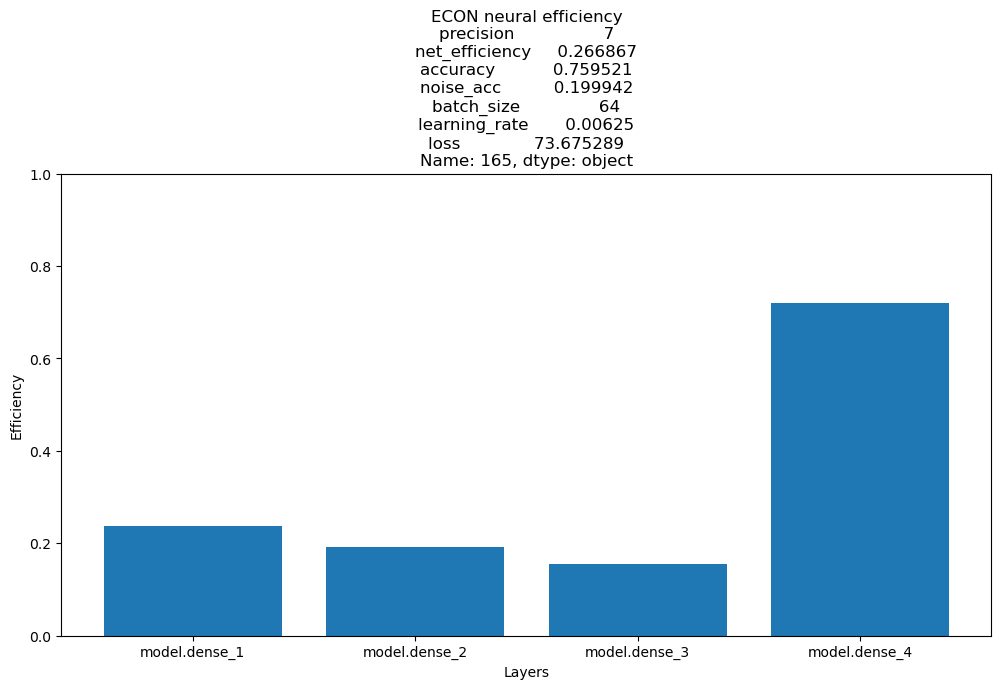

--------------------------------------------------------------------------------
High loss
Accuracy:	0.7611416697502136
Loss:	73.9585267415526
Network efficiency:	0.28256395314316163


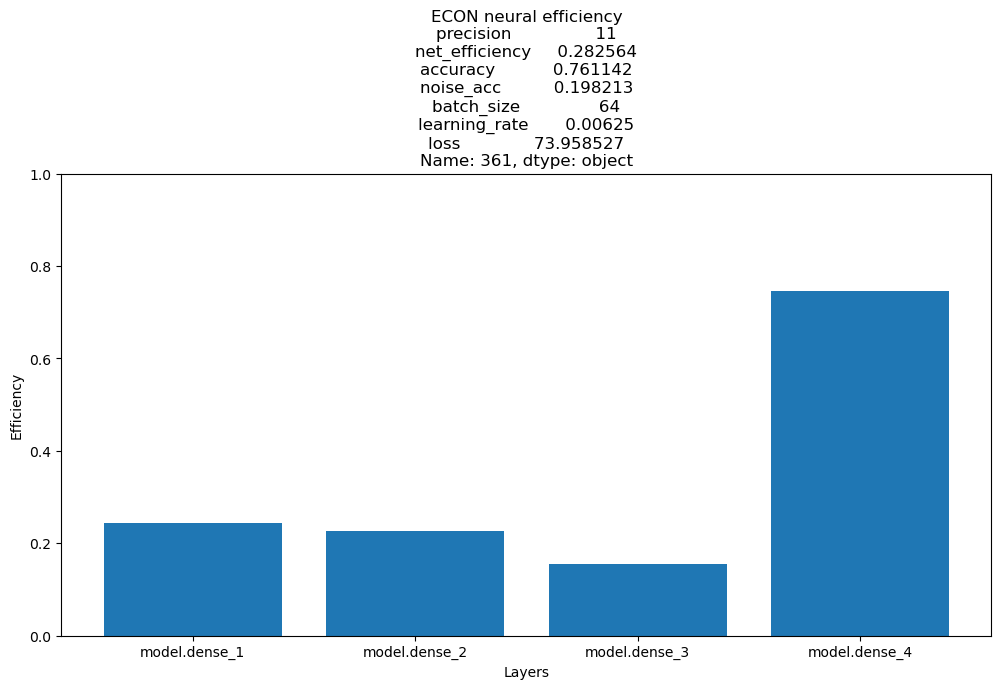

In [ ]:
worst_df = ne_distribution_df.tail(NUM_PLOT)

for i in range(NUM_PLOT):
    print('-'*80)
    print('High loss')
    result = get_neural_efficiency(int(worst_df.iloc[i]['batch_size']),
                                   float(worst_df.iloc[i]['learning_rate']), 
                                   int(worst_df.iloc[i]['precision']),
                                   ne_dataloader,
                                   max_batches=ne_batch_num)
    print(f"Accuracy:\t{worst_df.iloc[i]['accuracy']}\n" \
          f"Loss:\t{worst_df.iloc[i]['loss']}\n" \
          f"Network efficiency:\t{worst_df.iloc[i]['net_efficiency']}")

    plot_neural_efficiency_per_layer(result['layers_efficiency'], 
                                     'ECON neural efficiency\n' \
                                     f'{worst_df.iloc[i]}')